In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Image Input!


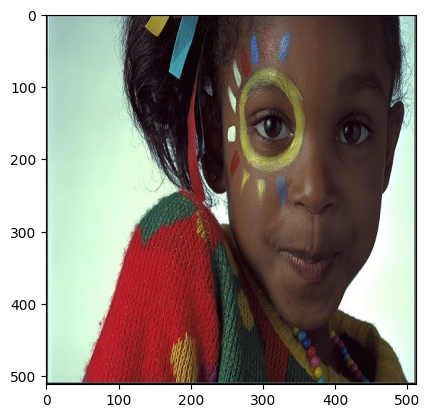

Image Resized!


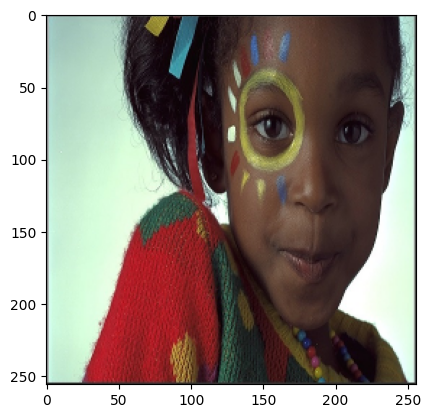

Image Input to Y-Network!


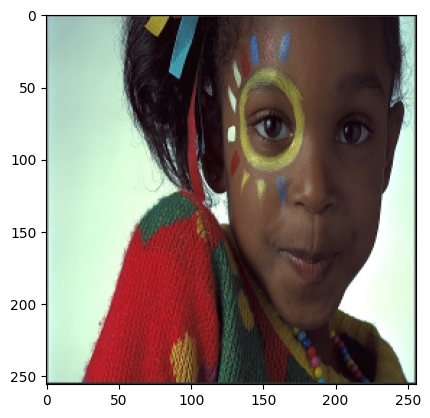

262144
Flattened dimension: 262144
End of encoder: <KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_24>
End of decoder: <KerasTensor shape=(None, 32, 32, 256), dtype=float32, sparse=False, name=keras_tensor_26>


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_24CLONE (InputLayer)    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 262144)              │      33,816,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 32, 32, 256)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,816,576 (129.00 MB)

 Trainable params: 33,816,576 (129.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, concatenate, Reshape
from tensorflow.keras.models import Model
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
from PIL import Image

# Load the image (replace 'path/to/your/image.jpg' with your image path)
image = cv2.imread('/content/gdrive/MyDrive/jpg_Set5/kodim15 (1).jpg')

print("Image Input!")
plt.imshow(image[:,:,::-1])  # Show BGR image in RGB format
plt.show()

# Resize the image to 256x256
resized_image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)

print("Image Resized!")
plt.imshow(resized_image[:,:,::-1])  # Show BGR image in RGB format
plt.show()

# Save the resized image
cv2.imwrite('/content/gdrive/MyDrive/jpg_Set5/kodim15 (1)_256_Colour.jpg', resized_image)
#print(f"Resized image saved to {output_path}")

OrgImg = resized_image

# Assuming your image is a NumPy array of shape (height, width, channels)
image1 = resized_image
height = image1.shape[0]
width = image1.shape[1]
channels = 3  # Assuming the image has 3 color channels (BGR)

# Input layer
input_img = Input(shape=(width, height, channels))

image1 = image1/ 255.0  # Normalize image between 0 and 1
image1 = image1.reshape((1, 256, 256, channels))  # Add batch and channel dimensions

print("Image Input to Y-Network!")
plt.imshow(image1.reshape(256,256, channels)[:,:,::-1])  # Show BGR image in RGB format
plt.show()

# network parameters
input_shape = (width, height, channels)
batch_size = 1
kernel_size = 3
dropout = 0.0
n_filters = 32

# left branch of Y network
left_inputs = Input(shape=input_shape)
x = left_inputs
filters = n_filters

# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(3):
  x = Conv2D(filters=filters,
            kernel_size=kernel_size,
            padding='same',
            activation='relu')(x)
  x = Dropout(dropout)(x)
  x = MaxPooling2D()(x)
  filters *= 2

# right branch of Y network
right_inputs = Input(shape=input_shape)
y = right_inputs
filters = n_filters

# 3 layers of Conv2D-Dropout-MaxPooling2Do
# number of filters doubles after each layer (32-64-128)
for i in range(3):
  y = Conv2D(filters=filters,
            kernel_size=kernel_size,
            padding='same',activation='relu',
            dilation_rate=2)(y)
  y = Dropout(dropout)(y)
  y = MaxPooling2D()(y)
  filters *= 2



print(y.shape[1])
#Calculate the total number of elements after flattening
flattened_dim = np.prod(y.shape[1:])
print(f"Flattened dimension: {flattened_dim}")

# Autoencoder
encoded_dim = 128  # 32 #64 #256 # Dimension of the compressed representation
encoded = Dense(encoded_dim, activation='relu')(y)
print(f"End of encoder: {encoded}")

# Decoder
decoded = Dense(np.prod(y.shape[1:]), activation='relu')(encoded)
decoded = Reshape((32, 32, 256))(decoded)
print(f"End of decoder: {decoded}")

# Define the autoencoder model separately
autoencoder = Model(inputs=encoded, outputs=decoded)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

# Print the autoencoder model summary
autoencoder.summary()

#Save the autoencoder model separately
autoencoder.save('autoencoder_Ynet_model.h5')


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, concatenate, Reshape
from tensorflow.keras.models import Model
# Determine the shape to reshape y back into
#reshaped_shape = (32, 32, 256)
#reshaped_shape = (width, height, 32)
#print("Shape to reshape into:", reshaped_shape)

# Determine the shape to reshape y back into
reshaped_shape = (32, 32, 256)  # Ensure this matches the total number of elements
print("Shape to reshape into:", reshaped_shape)

# Reshape y back into a tensor
y = Reshape(reshaped_shape)(y)

filters=128
# Apply UpSampling and Conv2D layers to reconstruct the image
for i in range(3):
    decoded  = UpSampling2D()(decoded )
    decoded  = Conv2D(filters=filters // 2, kernel_size=kernel_size, padding='same', activation='relu')(decoded)
    filters //= 2
print("Shape after upsampling", decoded.shape)

# Final convolution layer to reconstruct the image
output_img = Conv2D(3, kernel_size=(3, 3), padding='same', activation='sigmoid')(decoded)
print("Shape after convolution:", output_img.shape)

# Create and compile the model
model = Model(inputs=[left_inputs, right_inputs], outputs=output_img)
model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()

model.save('/content/gdrive/MyDrive/jpg_Set5/YnetAutoencoder_model.h5')

# Visualize the input image
#rint("Input Image in cell2")
#plt.imshow(image1)  # Show BGR image in RGB format
#plt.show()

# Normalize the image and reshape to include batch and channel dimensions
#image = image1 / 255.0  # Normalize image between 0 and 1
#image = image1.reshape((1, 256, 256, 1))  # Add batch and channel dimensions


# Assuming you have the ground truth image (for demonstration purposes, use the same input image)
ground_truth = image1

# Train the model (for demonstration, use the same image as both input and output)
model.fit([image1,image1], ground_truth, epochs=1000, batch_size=1)

# Predict and visualize the reconstructed image
reconstructed_img = model.predict([image1, image1])
reconstructed_img = reconstructed_img.reshape(256, 256,3)
print(reconstructed_img)

# Convert the reconstructed image back to the range [0, 255]
reconstructed_img = (reconstructed_img * 255).astype(np.uint8)
print(reconstructed_img)


#output_img.reshape(256,256, 3)
reconstructed_img_RGB = cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB)
plt.imshow(reconstructed_img)
plt.title('Reconstructed Image')
plt.show()

plt.imshow(reconstructed_img_RGB)
plt.title('Reconstructed Image')
plt.show()

# Save the reconstructed image as a JPEG file
cv2.imwrite('/content/gdrive/MyDrive/jpg_Set5/kodim15 (1)AEN128reconstructed_Colour_1000.jpg', reconstructed_img_RGB)



Shape to reshape into: (32, 32, 256)
Shape after upsampling (None, 2048, 2048, 16)
Shape after convolution: (None, 2048, 2048, 3)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 32)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256, 256, 32)   │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 128, 128, 32)   │              0 │ dropout_3[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128, 128, 64)   │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ dropout_4[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)  

 Total params: 67,761,043 (258.49 MB)

 Trainable params: 67,761,043 (258.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


ValueError: Dimensions must be equal, but are 256 and 2048 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](data_2, functional_2_1/conv2d_13_1/Sigmoid)' with input shapes: [1,256,256,3], [1,2048,2048,3].

Image Resized!


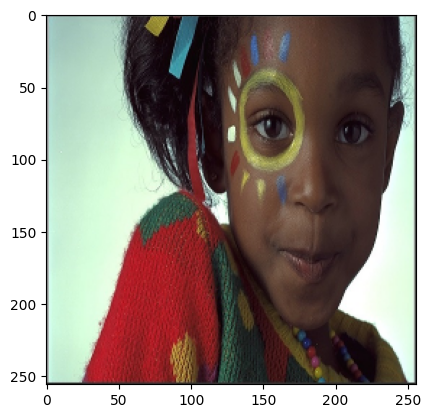

Image Reconstructed!


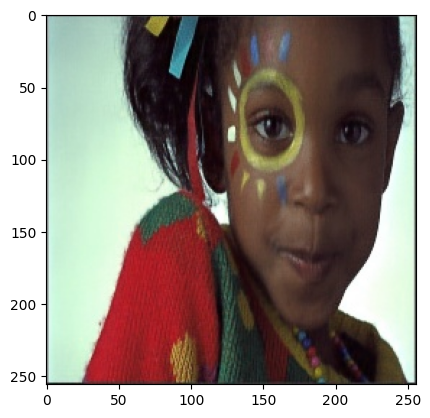

PSNR: 35.298618140648216, SSIM: 0.8895837864087079


In [ ]:
# Compute PSNR and SSIM
#original_image = (OrgImg.reshape(256, 256) * 255).astype(np.uint8)
#reconstructed_image = (reconstructed_img * 255).astype(np.uint8)

# Load the image (replace 'path/to/your/image.jpg' with your image path)
image = cv2.imread('/content/gdrive/MyDrive/jpg_Set5/kodim15 (1).jpg')
image_reconstructed=cv2.imread('/content/gdrive/MyDrive/jpg_Set5/kodim15 (1)AEN128reconstructed_Colour_1000.jpg')

reconstructed_img_RGB = cv2.cvtColor(image_reconstructed, cv2.COLOR_BGR2RGB)

# Resize the image to 256x256
resized_image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)

print("Image Resized!")
plt.imshow(resized_image[:,:,::-1])  # Show BGR image in RGB format
plt.show()
print("Image Reconstructed!")
plt.imshow(reconstructed_img_RGB[:,:,::-1])  # Show BGR image in RGB format
plt.show()


def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def ssim(img1, img2):
    #return compare_ssim(img1, img2)
    return compare_ssim(img1, img2, win_size=3, channel_axis=-1)  # Set win_size and handle RGB



psnr_value = psnr(resized_image, reconstructed_img_RGB)
ssim_value = ssim(resized_image, reconstructed_img_RGB)

print(f'PSNR: {psnr_value}, SSIM: {ssim_value}')